# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 3
This notebook reproduces the figures from poster panel 3. Panel 3 compares spiking statistics between cognitive and behavioral states.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# settings - directories
PROJECT_PATH = 'G:/Shared drives/visual_encoding'

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import neo
import warnings
warnings.filterwarnings("ignore")

In [4]:
# custom
import sys
sys.path.append("../../")
from allen_vc.plots import sync_plot
from allen_vc.stats import sync_stats, run_hierarchical_bootstrap

print("Packages Imported")

Packages Imported


### Settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]


### load results

In [6]:
# load spike stats from spontaneous block
df_running = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/unit_metrics/spontaneous_running.csv').assign(state='running').assign(block='behavior')
df_stationary = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/unit_metrics/spontaneous_stationary.csv').assign(state='stationary').assign(block='behavior')

# load spike stats from movie blocks
df_movie = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/unit_metrics/natural_movie_one_more_repeats.csv').assign(state='movie').assign(block='presentation')
df_shuffled = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/unit_metrics/natural_movie_one_shuffled.csv').assign(state='shuffled').assign(block='presentation')

# join
metric_df = pd.concat([df_running, df_stationary, df_movie, df_shuffled], ignore_index=True).drop(columns=['running'])

In [7]:
metric_df

,session,brain_structure,epoch_idx,epoch_times,firing_rate,coef_variation,fano_factor,unit_index,state,block
0,847657808,VISp,0,"[5512.0, 5542.0]",14.533333,1.154701764489129,3.173089,0,running,behavior
1,847657808,VISp,0,"[5512.0, 5542.0]",22.733333,0.910858309974277,2.480743,1,running,behavior
2,847657808,VISp,0,"[5512.0, 5542.0]",4.966667,1.311300511305347,2.033333,2,running,behavior
3,847657808,VISp,0,"[5512.0, 5542.0]",3.700000,1.349857495963888,1.570270,3,running,behavior
4,847657808,VISp,0,"[5512.0, 5542.0]",3.066667,1.1913324856664866,1.237681,4,running,behavior
...,...,...,...,...,...,...,...,...,...,...
239413,766640955,LGd,19,"[7371.452864154053, 7401.46]",0.733333,0.9738043445103077,0.993939,71,shuffled,presentation
239414,766640955,LGd,19,"[7371.452864154053, 7401.46]",12.133333,1.2333447531000277,1.207326,72,shuffled,presentation
239415,766640955,LGd,19,"[7371.452864154053, 7401.46]",20.433333,1.0824597881338314,1.470419,73,shuffled,presentation
239416,766640955,LGd,19,"[7371.452864154053, 7401.46]",14.400000,1.0705387121990564,0.863889,74,shuffled,presentation


In [8]:
metric_df.isna().sum()

session               0
brain_structure       0
epoch_idx             0
epoch_times           0
firing_rate           0
coef_variation     2177
fano_factor        2047
unit_index            0
state                 0
block                 0
dtype: int64

In [23]:
metric_df.dropna(inplace=True)

In [24]:
metric_df.dtypes

session              int64
brain_structure     object
epoch_idx            int64
epoch_times         object
firing_rate        float64
coef_variation      object
fano_factor        float64
unit_index           int64
state               object
block               object
dtype: object

In [25]:
metric_df['coef_variation'] = metric_df['coef_variation'].astype('float64')

In [71]:
# remove NaNs from the data
# metric_df = metric_df.dropna(subset=['mean_firing_rate', 'spike_distance'])

## Main

### Spike-distance graphic

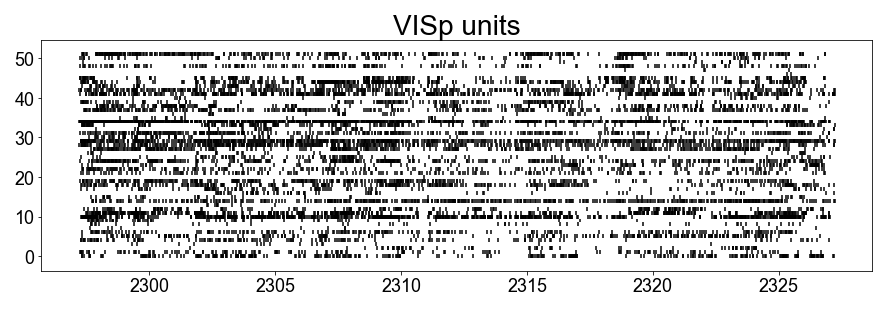

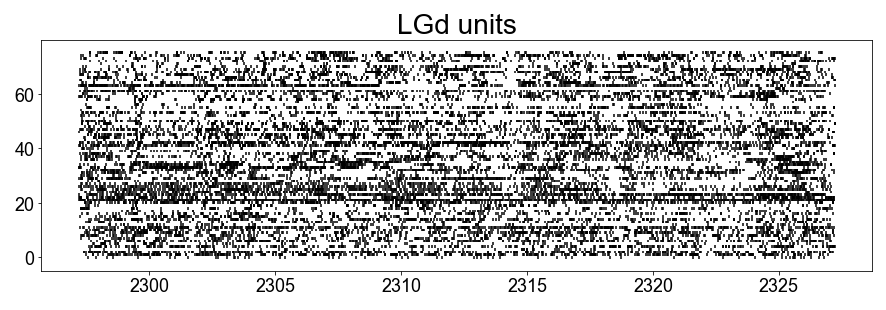

In [27]:
# load example data block
stim_code = 'natural_movie_one_more_repeats'
path_in = f"{PROJECT_PATH}/data/blocks/segmented/{stim_code}"
files = os.listdir(path_in)
fname_in = files[0] # first file
block = neo.io.NeoMatlabIO(f"{path_in}/{fname_in}").read_block()
segment = block.segments[0] # first segment

# get spike times for each region and plot
for region in ['VISp', 'LGd']:
    spike_trains = segment.filter(objects=neo.SpikeTrain, targdict={'brain_structure': region})
    spike_times = [st.times for st in spike_trains]

    # plot spikes
    fig_1, ax_1 = plt.subplots(figsize=(12, 4))
    ax_1.eventplot(spike_times, color='k')
    ax_1.set_title(f"{region} units")


### State comparison - violin plots
compare mean spike stats between states

In [26]:
# define metrics to be plotted 
metrics = ['firing_rate', 'coef_variation']
conditions = ['running', 'stationary', 'movie', 'shuffled']

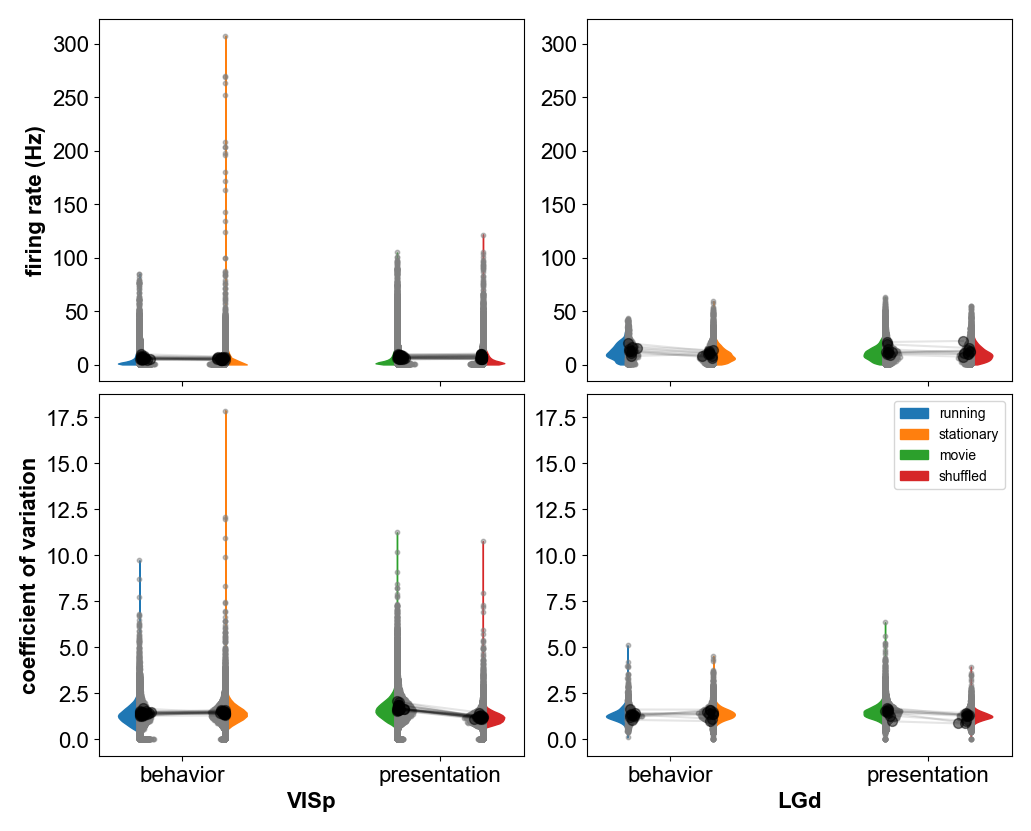

In [29]:
# plot all units
sync_plot(metric_df.dropna(), metrics, conditions, ylabels=['firing rate (Hz)', 'coefficient of variation']);

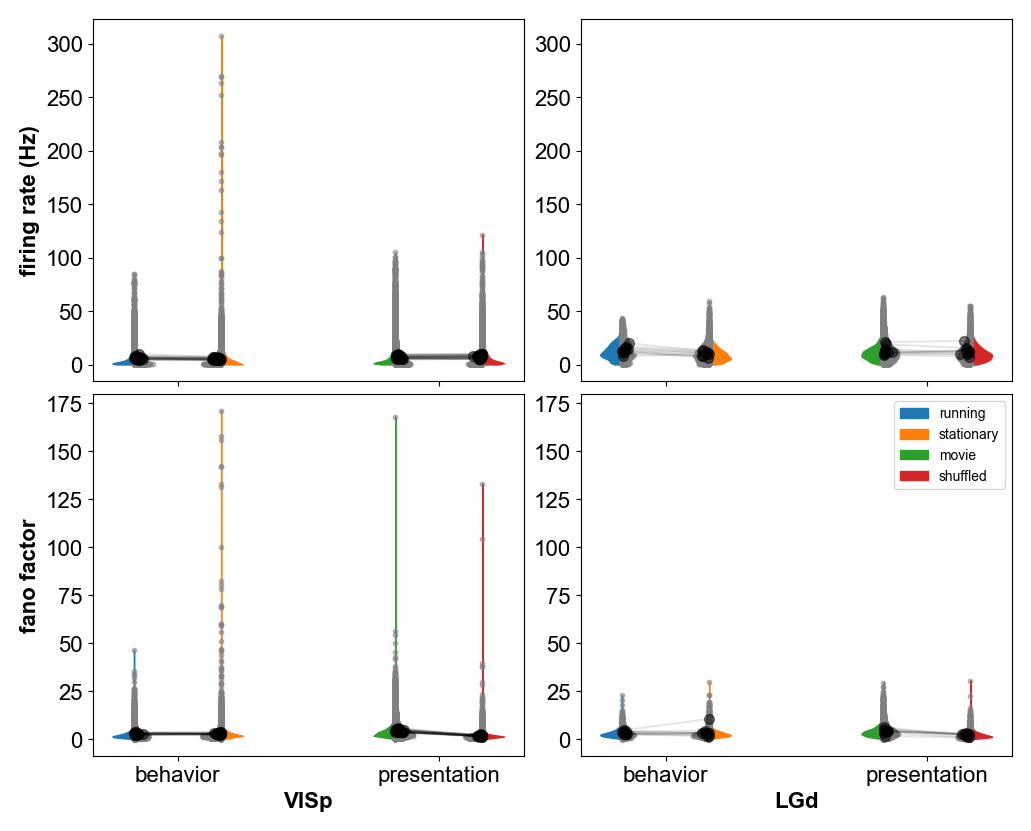

In [30]:
# plot all epochs
metrics = ['firing_rate', 'fano_factor']
sync_plot(metric_df.dropna(), metrics, conditions, ylabels=['firing rate (Hz)', 'fano factor']);

#### Hierarchical bootstrap

In [33]:
# run hierarchical bootstrap

# Set default parameters for hierarchical bootstrap
bootstrap_params = {
    'df': None,
    'variable': None,
    'condition': 'state',
    'level_1': 'unit_index',
    'level_2': 'session',
    'verbose': True,
    'plot': True
}

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'firing_rate' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.28
p-boot: 0.7377079999999999


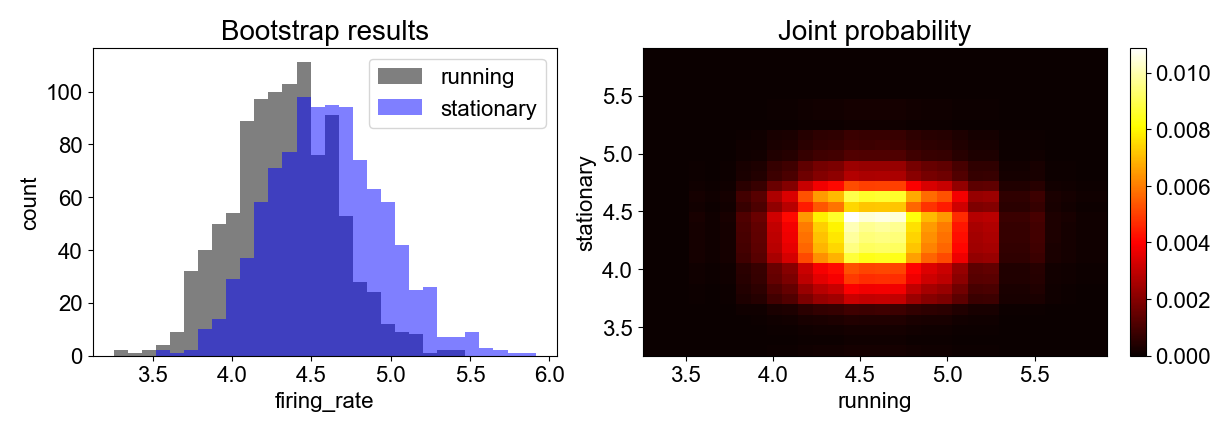

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'firing_rate' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.164
p-boot: 0.191203


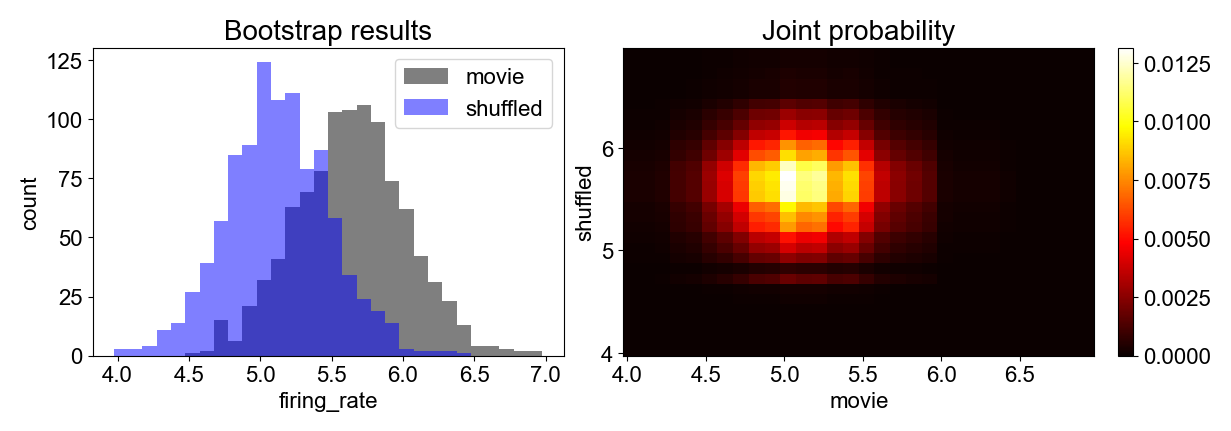

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'firing_rate' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.198
p-boot: 0.218747


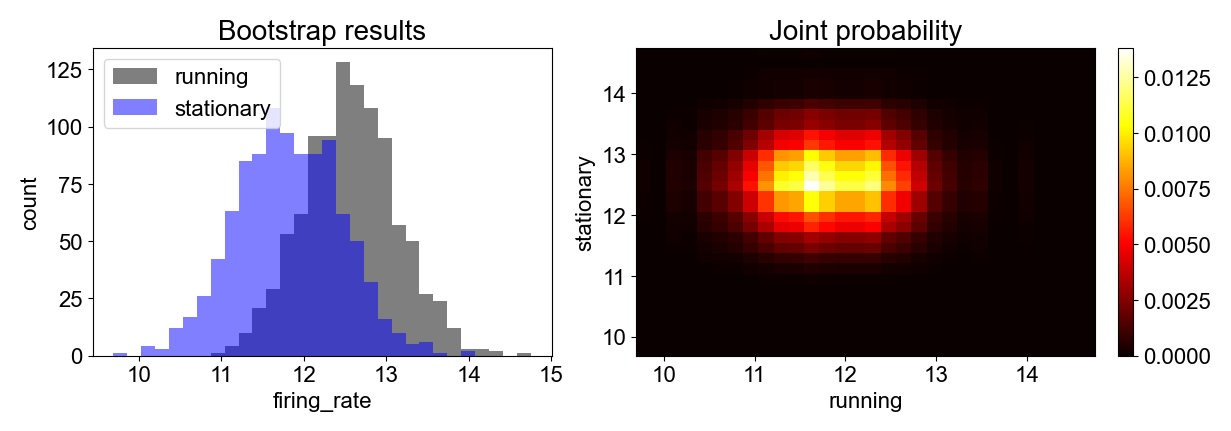

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'firing_rate' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.175
p-boot: 0.842385


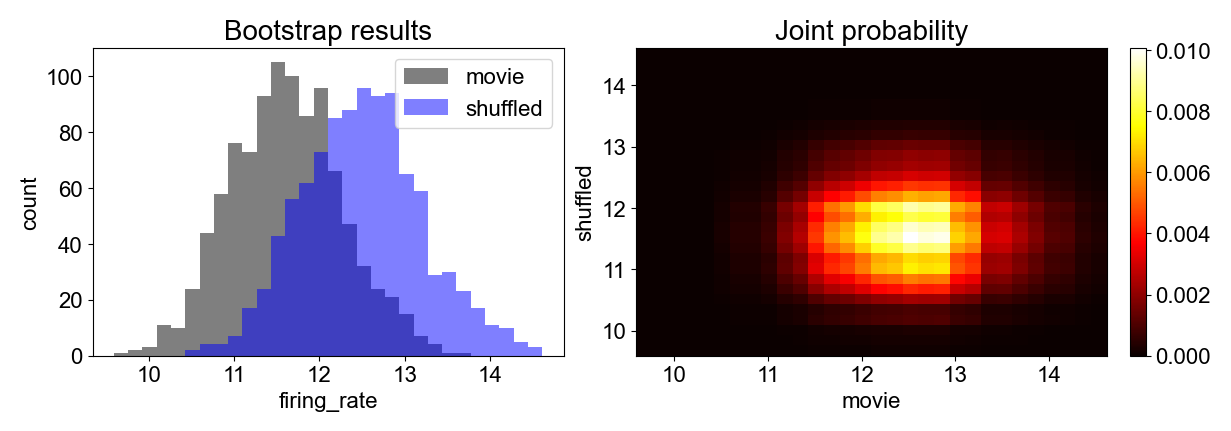

In [34]:
# firing rate analysis
variable = 'firing_rate'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'coef_variation' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.346
p-boot: 0.371251


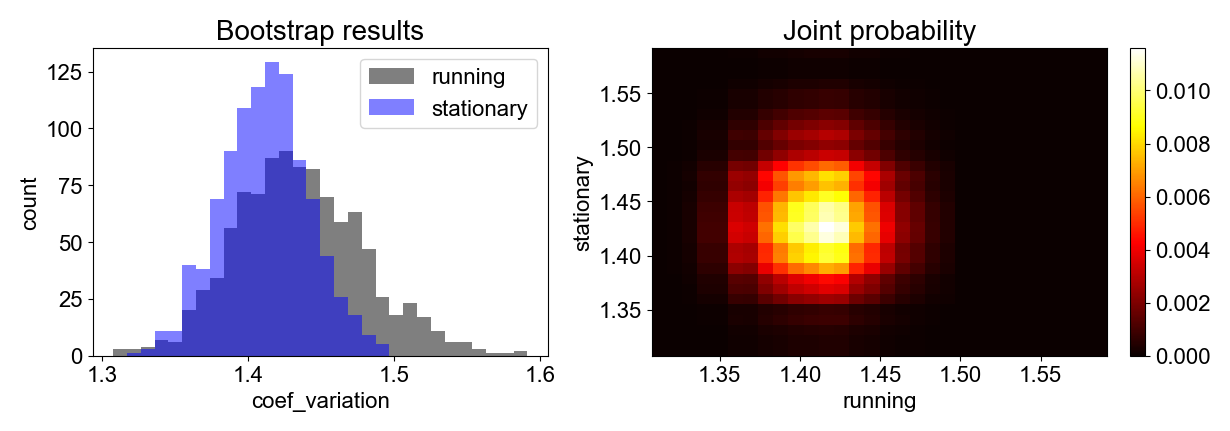

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'coef_variation' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.0
p-boot: 0.0


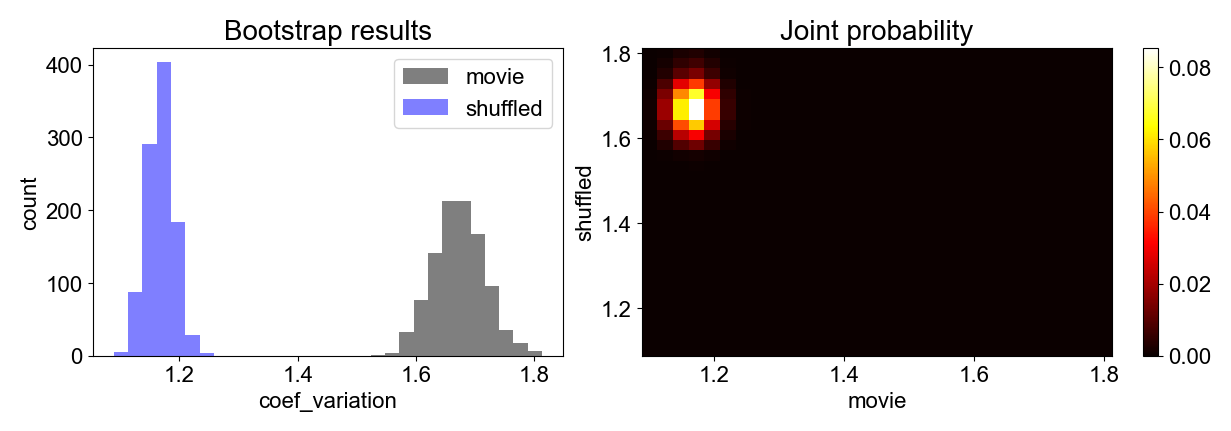

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'coef_variation' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.413
p-boot: 0.44097299999999995


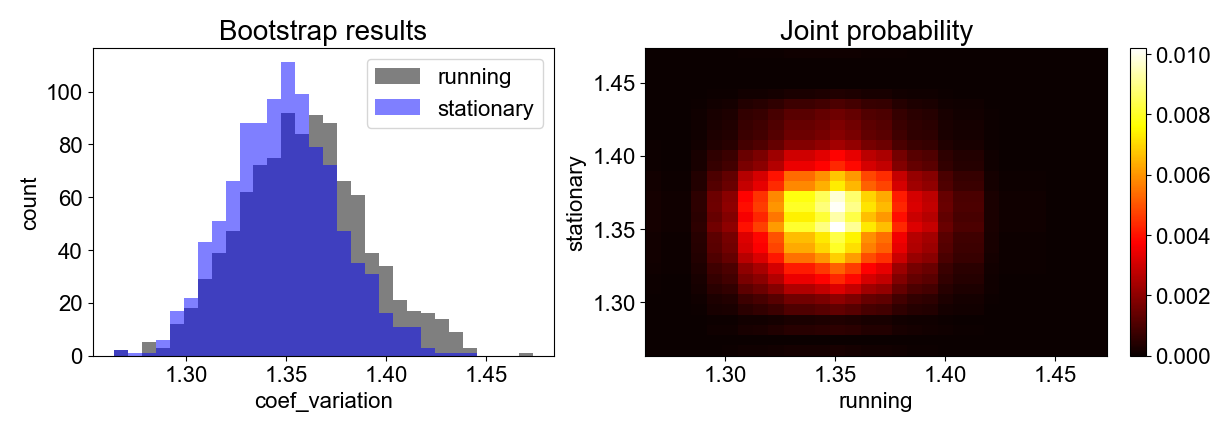

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'coef_variation' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.0
p-boot: 0.0


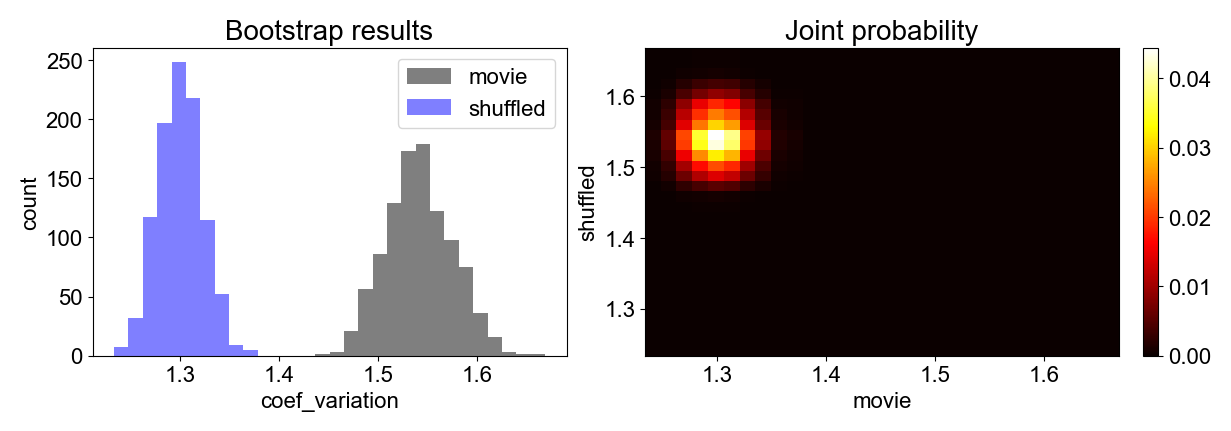

In [35]:
# coefficient of variation analysis
variable = 'coef_variation'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'fano_factor' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.054
p-boot: 0.07485299999999999


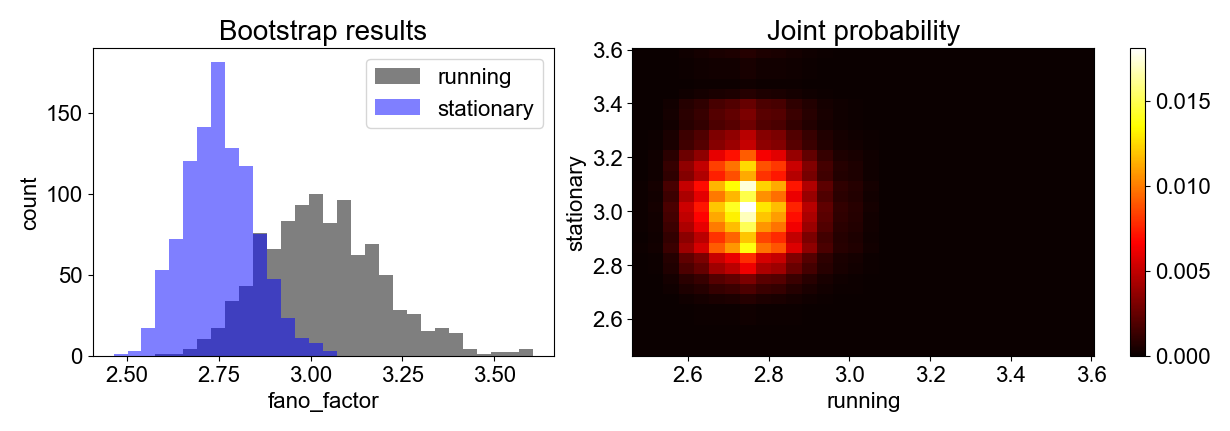

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'fano_factor' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.0
p-boot: 0.0


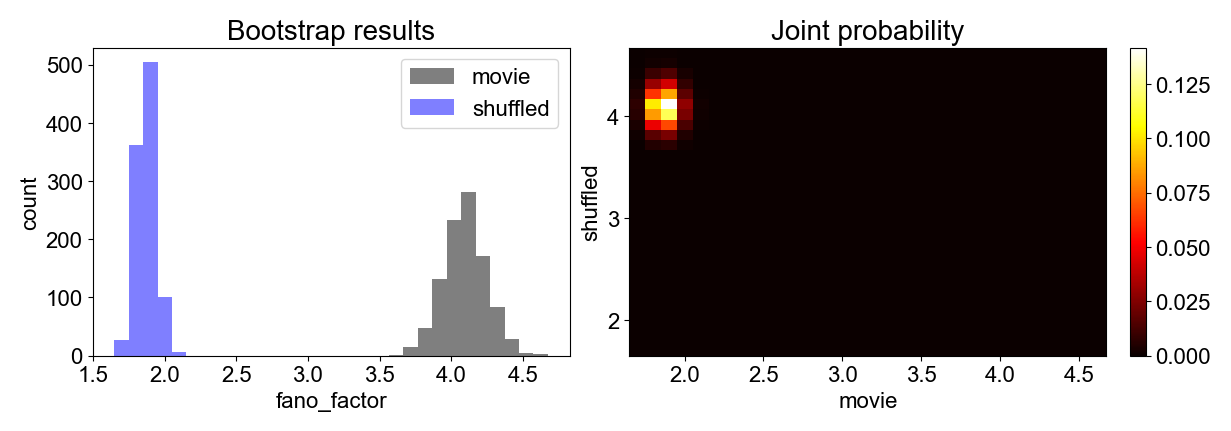

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'fano_factor' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.36
p-boot: 0.40611300000000006


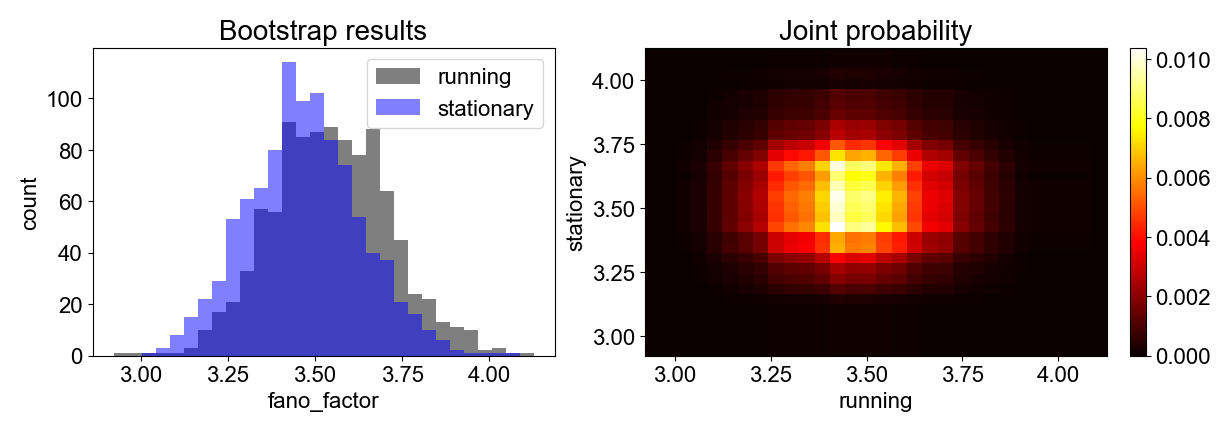

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'fano_factor' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.0
p-boot: 0.0


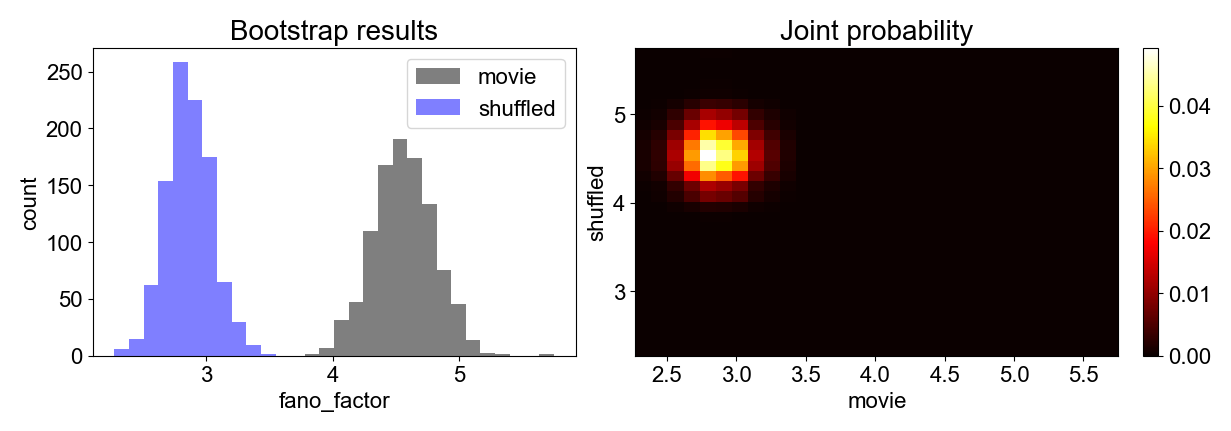

In [36]:
# fano factor analysis
variable = 'fano_factor'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

### Cell below contains epoch averaged statistics

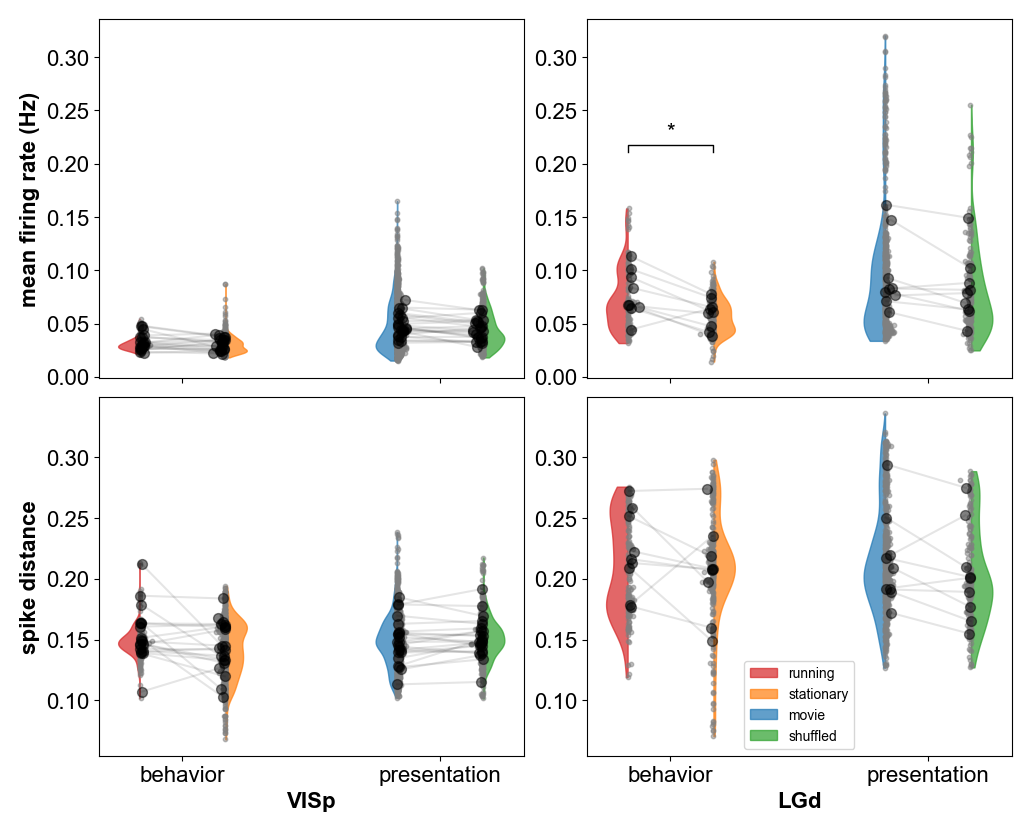

In [81]:
# plot all epochs - without outliers 

# identify clear outliers in SPIKE-distance
# metric_df[metric_df['spike_distance'] < 0.25]

p_vals = [[0.229, 0.132], [0.054, 0.319], [0.011, 0.165], [0.158,0.246]]
colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c']

# remove outliers
no_outliers_metric_df = metric_df[metric_df['spike_distance'] < 1]

# plot
sync_plot(no_outliers_metric_df, metrics, conditions, p_vals=p_vals, alpha=0.7, 
          ylabels=['mean firing rate (Hz)', 'spike distance'], colors=colors);

### State comparison - statistics

#### paired t-test

In [15]:
# post hoc tests

# look at diffs between running and stationary
print("ALL DATA\n\n\n")
sync_stats(metric_df, metrics, condition)

ALL DATA



REGION: VISp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

METRIC: mean_firing_rate

Behavior: running
N = 299
Mean = 5.465580295498224
Stdev = 1.0403099076367723

Behavior: stationary
N = 664
Mean = 5.26230657490645
Stdev = 1.2942527706427738

Independent T-Test (All data)
Ttest_indResult(statistic=2.387782255703683, pvalue=0.017142729928100845)


----------------------------------------------------------------------------------------------------

METRIC: spike_distance

Behavior: running
N = 299
Mean = 0.15176473357254963
Stdev = 0.050712125580077795

Behavior: stationary
N = 664
Mean = 0.14136440288191174
Stdev = 0.02332860732494304

Independent T-Test (All data)
Ttest_indResult(statistic=4.354284135735598, pvalue=1.4782221542821623e-05)


----------------------------------------------------------------------------------------------------

REGION: LGd

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [16]:
print("GROUP AVERAGES\n\n\n")
sync_stats(ses_avg, metrics, condition, paired_ttest=True)

GROUP AVERAGES



REGION: LGd

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

METRIC: mean_firing_rate

Behavior: running
N = 9
Mean = 13.565424563038706
Stdev = 3.3131725941141275

Behavior: stationary
N = 9
Mean = 10.119672434648294
Stdev = 2.1876595072093843

Independent T-Test (All data)
Ttest_indResult(statistic=2.4547657022630522, pvalue=0.025924249373701313)

Paired T-Test
Ttest_relResult(statistic=3.949129112121454, pvalue=0.004241196973054426)


----------------------------------------------------------------------------------------------------

METRIC: spike_distance

Behavior: running
N = 9
Mean = 0.2221534179524424
Stdev = 0.03150251879059855

Behavior: stationary
N = 9
Mean = 0.2063264284351905
Stdev = 0.035200274597505556

Independent T-Test (All data)
Ttest_indResult(statistic=0.9476500163411974, pvalue=0.35740181725497144)

Paired T-Test
Ttest_relResult(statistic=1.3338701739542356, pvalue=0.21897012040046362)


---

#### hierarchical bootstrap

In [15]:
# Set default parameters for hierarchical bootstrap
bootstrap_params = {
    'df': None,
    'variable': None,
    'condition': 'state',
    'level_1': 'session',
    'level_2': 'epoch_idx',
    'verbose': True,
    'plot': True
}

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.229
p-boot: 0.25431400000000004


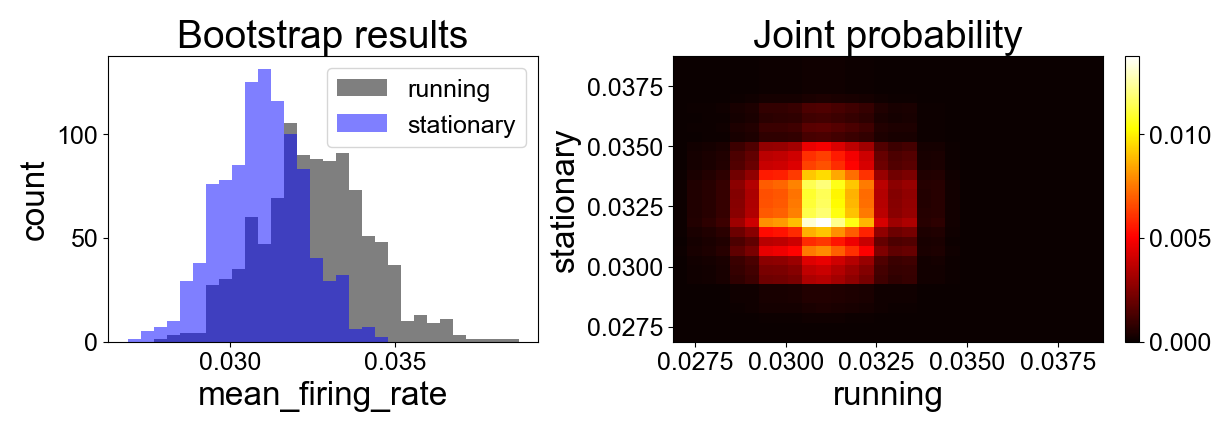

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.132
p-boot: 0.15208000000000002


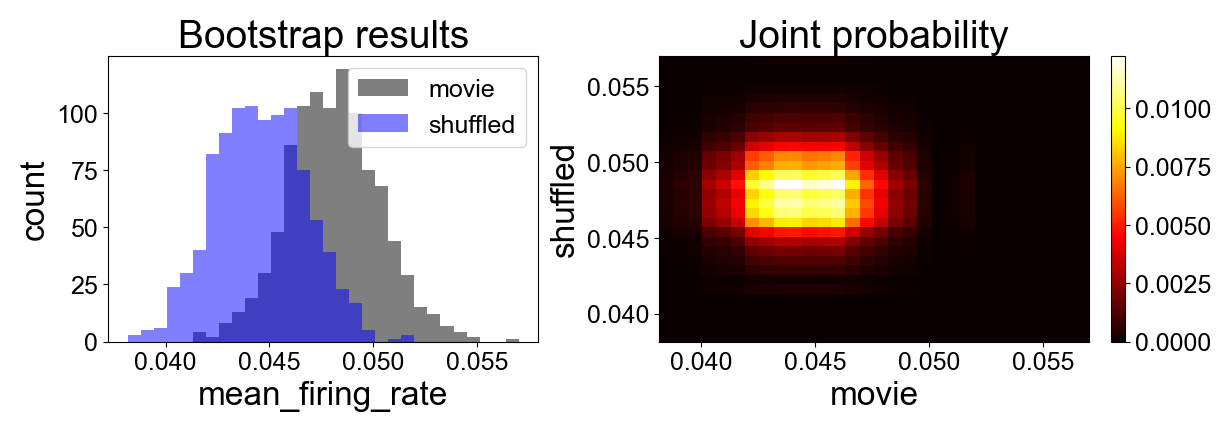

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.011
p-boot: 0.013954000000000001


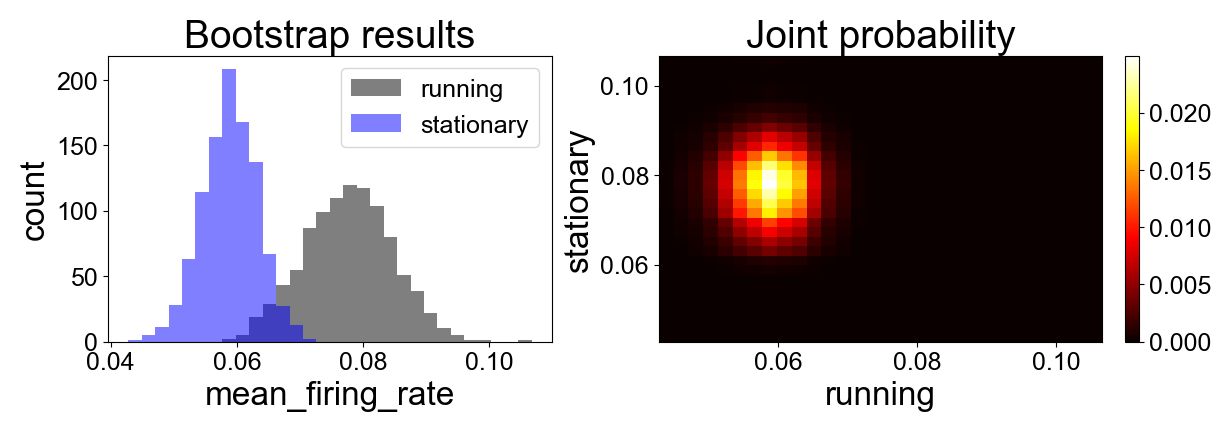

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.165
p-boot: 0.19773000000000002


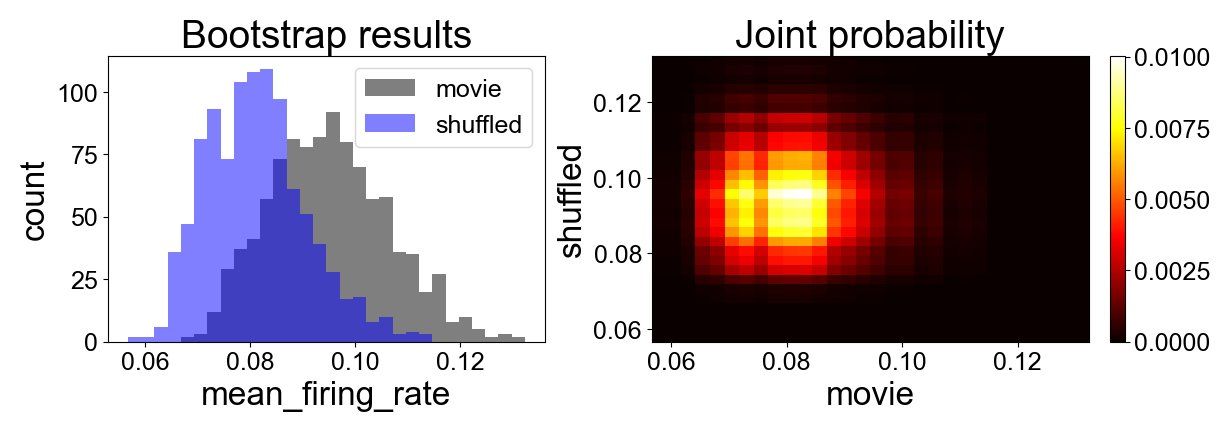

In [18]:
# offset analysis
variable = 'mean_firing_rate'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.054
p-boot: 0.05844


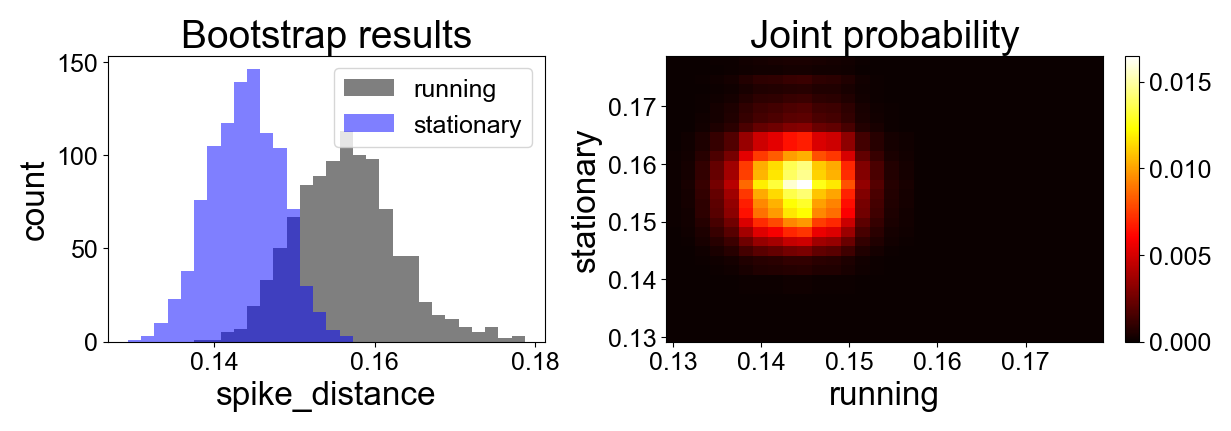

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.319
p-boot: 0.7155950000000001


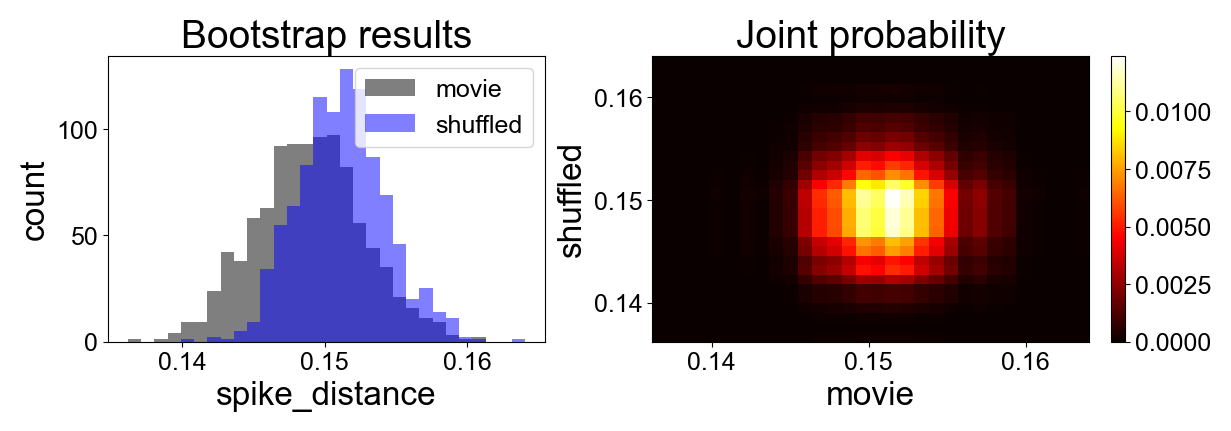

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.158
p-boot: 0.185853


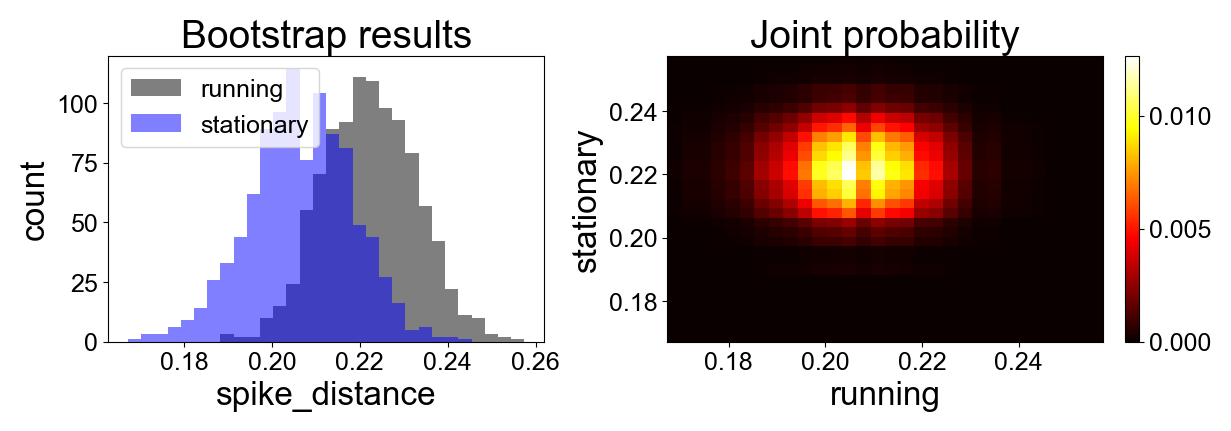

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.246
p-boot: 0.269458


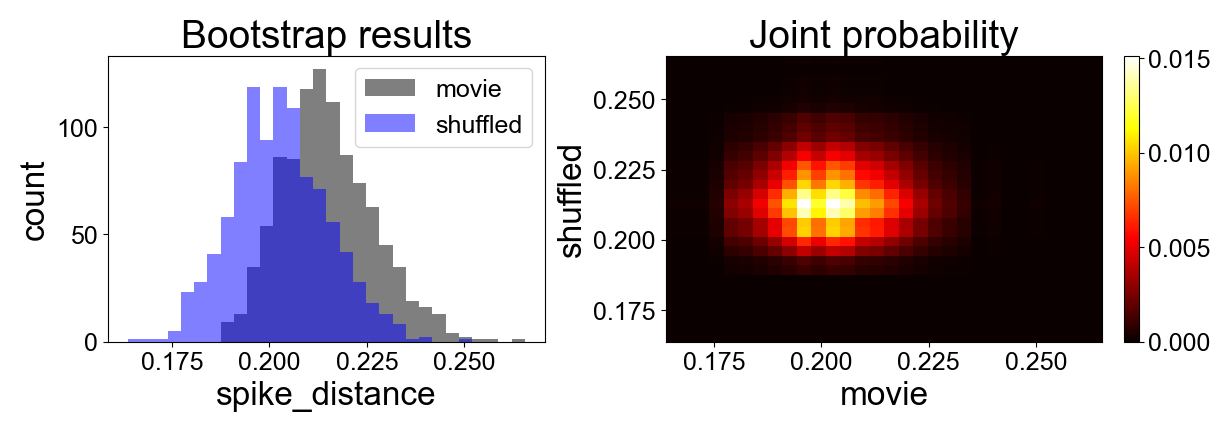

In [20]:
# spike-distance analysis
variable = 'spike_distance'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)